# Notebook 03 — KPI Calculations & Core Visualizations

**Objective**: Create comprehensive time-independent analyses with actionable insights.

**Key Analyses**:
- Revenue Performance by Platform (DSP Comparison)
- Artist & Track Performance Analysis
- Stream Type Distribution (Ad-supported vs Subscription)
- Caller Tune Revenue Analysis
- Revenue Concentration & Market Share
- Language & Regional Performance
- Advanced Analytics (Revenue per Stream, Artist Diversity, etc.)

In [80]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup Paths
DATA_PATH = Path('../outputs/cleaned/df_all.parquet')
FIGURES_DIR = Path('../outputs/figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Set Plot Style for Matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

In [81]:
# Load Data
try:
    df_all = pd.read_parquet(DATA_PATH)
    print(f"Loaded data with shape: {df_all.shape}")
    # Ensure year_month is sorted for plotting
    df_all = df_all.sort_values('year_month')
except FileNotFoundError:
    print("Data file not found. Please run Notebook 02 first.")

Loaded data with shape: (8882, 12)


## 1. Core KPI Calculations

In [82]:
# 1. Overall Performance Metrics
total_revenue = df_all['revenue'].sum()
total_streams = df_all['stream_count'].sum()
unique_artists = df_all['artist'].nunique()
unique_tracks = df_all['track'].nunique()
avg_revenue_per_stream = total_revenue / total_streams if total_streams > 0 else 0

print("="*60)
print("OVERALL PERFORMANCE DASHBOARD")
print("="*60)
print(f"Total Revenue:              ₹{total_revenue:,.2f}")
print(f"Total Streams:              {total_streams:,.0f}")
print(f"Avg Revenue per Stream:     ₹{avg_revenue_per_stream:.6f}")
print(f"Unique Artists:             {unique_artists:,}")
print(f"Unique Tracks:              {unique_tracks:,}")
print("="*60)

OVERALL PERFORMANCE DASHBOARD
Total Revenue:              ₹29,700.78
Total Streams:              497,421
Avg Revenue per Stream:     ₹0.059710
Unique Artists:             2,459
Unique Tracks:              6,672


In [83]:
# 2. Platform Performance Analysis (DSP Comparison)
dsp_analysis = df_all.groupby('store_name', as_index=False).agg(
    total_revenue=('revenue', 'sum'),
    total_streams=('stream_count', 'sum'),
    unique_tracks=('track', 'nunique'),
    unique_artists=('artist', 'nunique')
).sort_values('total_revenue', ascending=False)

dsp_analysis['revenue_share_%'] = (dsp_analysis['total_revenue'] / total_revenue) * 100
dsp_analysis['avg_revenue_per_stream'] = dsp_analysis['total_revenue'] / dsp_analysis['total_streams']
dsp_analysis['avg_revenue_per_track'] = dsp_analysis['total_revenue'] / dsp_analysis['unique_tracks']

print("\nPLATFORM PERFORMANCE COMPARISON")
print("="*60)
display(dsp_analysis)


PLATFORM PERFORMANCE COMPARISON


,store_name,total_revenue,total_streams,unique_tracks,unique_artists,revenue_share_%,avg_revenue_per_stream,avg_revenue_per_track
1,Wynk Music,22760.579356,404885.0,5731,2064,76.632936,0.056215,3.971485
0,JioSaavn,6940.200000,92536.0,2554,877,23.367064,0.075000,2.717384


In [84]:
# 3. Stream Type Analysis (Ad-supported vs Subscription)
# Extract stream type info from JioSaavn data
stream_type_analysis = df_all[df_all['source'] == 'jiosaavn'].copy()

if len(stream_type_analysis) > 0:
    # Note: We'd need the raw columns to differentiate ad_supported vs subscription
    # For now, aggregate by source and unit_type
    stream_dist = df_all.groupby(['source', 'unit_type'], as_index=False).agg(
        revenue=('revenue', 'sum'),
        streams=('stream_count', 'sum')
    )
    print("\nSTREAM TYPE DISTRIBUTION")
    print("="*60)
    display(stream_dist)
else:
    print("Stream type breakdown not available in cleaned data.")


STREAM TYPE DISTRIBUTION


,source,unit_type,revenue,streams


In [85]:
# 4. Top Performers Analysis
top_artists = df_all.groupby('artist', as_index=False).agg(
    total_revenue=('revenue', 'sum'),
    total_streams=('stream_count', 'sum'),
    track_count=('track', 'nunique')
).sort_values('total_revenue', ascending=False)
top_artists['revenue_per_track'] = top_artists['total_revenue'] / top_artists['track_count']
top_artists['revenue_per_stream'] = top_artists['total_revenue'] / top_artists['total_streams']

top_tracks = df_all.groupby(['track', 'artist'], as_index=False).agg(
    total_revenue=('revenue', 'sum'),
    total_streams=('stream_count', 'sum')
).sort_values('total_revenue', ascending=False)
top_tracks['revenue_per_stream'] = top_tracks['total_revenue'] / top_tracks['total_streams']

top_albums = df_all.groupby('album', as_index=False).agg(
    total_revenue=('revenue', 'sum'),
    total_streams=('stream_count', 'sum'),
    track_count=('track', 'nunique')
).sort_values('total_revenue', ascending=False)

print("\nTOP 10 ARTISTS BY REVENUE")
print("="*60)
display(top_artists.head(10))

print("\nTOP 10 TRACKS BY REVENUE")
print("="*60)
display(top_tracks.head(10))


TOP 10 ARTISTS BY REVENUE


,artist,total_revenue,total_streams,track_count,revenue_per_track,revenue_per_stream
708,F A Sumon,9318.861616,165875.0,10,931.886162,0.056180
944,Kaushik Chakraborty,998.393974,17704.0,3,332.797991,0.056394
235,Arijit Singh,755.228074,13443.0,3,251.742691,0.056180
1701,S.P. Venkatesh,677.850000,9038.0,10,67.785000,0.075000
1464,Pratik Sen,616.961729,8722.0,2,308.480865,0.070736
1990,Shreya Ghoshal,570.957592,10163.0,11,51.905236,0.056180
790,Iman Chakraborty,496.481979,8836.0,23,21.586173,0.056189
1689,Rupam Islam,479.578736,6762.0,12,39.964895,0.070923
190,Anupam Roy,475.938564,8404.0,8,59.492320,0.056632
1526,Rabindranath Tagore,422.400000,5632.0,27,15.644444,0.075000



TOP 10 TRACKS BY REVENUE


,track,artist,total_revenue,total_streams,revenue_per_stream
3542,Jaan Re Tui,F A Sumon,7509.752457,133673.0,0.056180
4464,Krishna Bhajan,Kaushik Chakraborty,992.286932,17603.0,0.056370
3433,Hoyto Tomari Jonno,Arijit Singh,736.744845,13114.0,0.056180
3639,Janere Khuda Jane,F A Sumon,673.879398,11995.0,0.056180
6012,Prithibita Naki Choto Hotey Hotey,Pratik Sen,616.024369,8709.0,0.070734
3643,Jani Dekha Howbe Female,Shreya Ghoshal,466.856006,8310.0,0.056180
5737,Pakhi,F A Sumon,409.552381,7290.0,0.056180
2292,Daniken,Rupam Islam,403.698823,5611.0,0.071948
2471,Dil Jane Na,Banasri Ghoshal,396.749720,5291.0,0.074986
5296,Nile Nile Ambar Par,Palash Das,319.720521,5691.0,0.056180


In [86]:
# 5. Language & Regional Analysis
language_analysis = df_all.groupby('source', as_index=False).agg(
    total_revenue=('revenue', 'sum'),
    total_streams=('stream_count', 'sum'),
    unique_artists=('artist', 'nunique'),
    unique_tracks=('track', 'nunique')
)

print("\nLANGUAGE/REGIONAL PERFORMANCE")
print("="*60)
display(language_analysis)

# Country Distribution
country_dist = df_all.groupby('country', as_index=False).agg(
    total_revenue=('revenue', 'sum'),
    total_streams=('stream_count', 'sum')
).sort_values('total_revenue', ascending=False)

print("\nCOUNTRY DISTRIBUTION")
print("="*60)
display(country_dist)


LANGUAGE/REGIONAL PERFORMANCE


,source,total_revenue,total_streams,unique_artists,unique_tracks
0,jiosaavn,6940.200000,92536.0,877,2554
1,wynk,22760.579356,404885.0,2064,5731



COUNTRY DISTRIBUTION


,country,total_revenue,total_streams
0,India,29700.779356,497421.0


In [87]:
# 6. Revenue Concentration & Market Power Analysis
def gini(x):
    """Calculate Gini coefficient for inequality measurement"""
    sorted_x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(sorted_x)
    return (2 * np.sum((n - np.arange(1, n + 1) + 1) * sorted_x)) / (n * cumsum[-1]) - 1

artist_revenues = top_artists['total_revenue'].values
track_revenues = top_tracks['total_revenue'].values

gini_artist = gini(artist_revenues)
gini_track = gini(track_revenues)

top_1_artist = top_artists.iloc[0]['total_revenue'] / total_revenue * 100
top_5_artists = top_artists.iloc[:5]['total_revenue'].sum() / total_revenue * 100
top_10_artists = top_artists.iloc[:10]['total_revenue'].sum() / total_revenue * 100
top_20_artists = top_artists.iloc[:20]['total_revenue'].sum() / total_revenue * 100

top_1_track = top_tracks.iloc[0]['total_revenue'] / total_revenue * 100
top_10_tracks = top_tracks.iloc[:10]['total_revenue'].sum() / total_revenue * 100
top_50_tracks = top_tracks.iloc[:50]['total_revenue'].sum() / total_revenue * 100

print("\nREVENUE CONCENTRATION ANALYSIS")
print("="*60)
print(f"Gini Coefficient (Artists):     {gini_artist:.4f} (0=perfect equality, 1=perfect inequality)")
print(f"Gini Coefficient (Tracks):      {gini_track:.4f}")
print(f"\nTop 1 Artist Share:             {top_1_artist:.2f}%")
print(f"Top 5 Artists Share:            {top_5_artists:.2f}%")
print(f"Top 10 Artists Share:           {top_10_artists:.2f}%")
print(f"Top 20 Artists Share:           {top_20_artists:.2f}%")
print(f"\nTop 1 Track Share:              {top_1_track:.2f}%")
print(f"Top 10 Tracks Share:            {top_10_tracks:.2f}%")
print(f"Top 50 Tracks Share:            {top_50_tracks:.2f}%")
print("="*60)


REVENUE CONCENTRATION ANALYSIS
Gini Coefficient (Artists):     -0.9332 (0=perfect equality, 1=perfect inequality)
Gini Coefficient (Tracks):      -0.9209

Top 1 Artist Share:             31.38%
Top 5 Artists Share:            41.64%
Top 10 Artists Share:           49.87%
Top 20 Artists Share:           60.26%

Top 1 Track Share:              25.28%
Top 10 Tracks Share:            42.17%
Top 50 Tracks Share:            59.59%


## 2. Core Visualizations

/tmp/ipykernel_53998/1406371945.py:37: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.

/tmp/ipykernel_53998/1406371945.py:38: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.

/home/parambrata-ghosh/Development/Personal/internship-assignment/reresumesubmissionparambrataghosh/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.



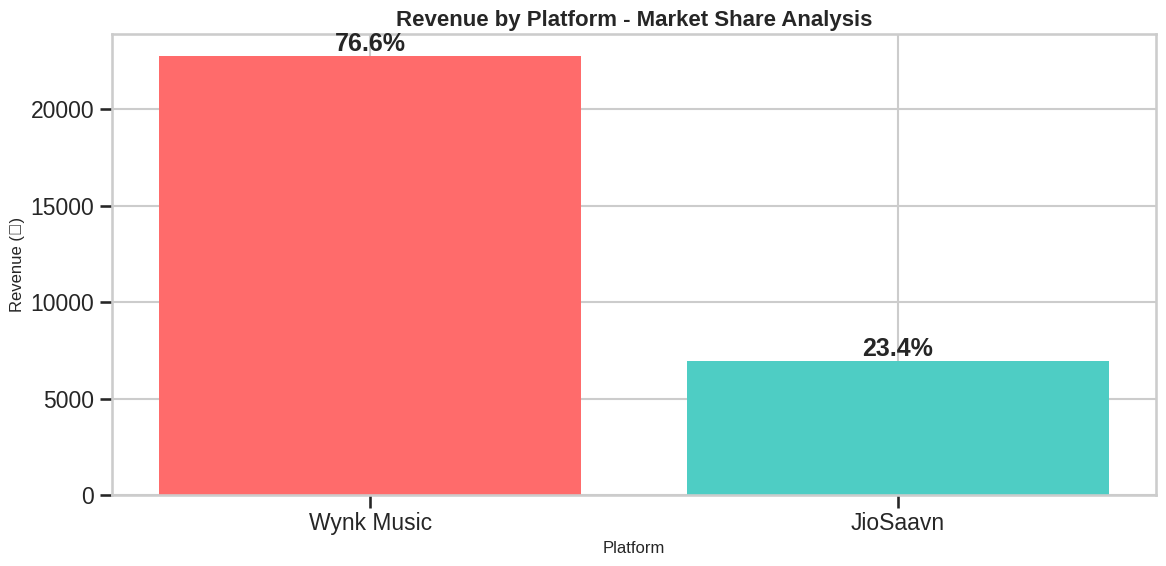

In [88]:
# 1. Platform Revenue Comparison with Market Share

fig_dsp = go.Figure()
fig_dsp.add_trace(go.Bar(
    x=dsp_analysis['store_name'],
    y=dsp_analysis['total_revenue'],
    name='Total Revenue',
    text=dsp_analysis['revenue_share_%'].apply(lambda x: f'{x:.1f}%'),
    textposition='outside',
    marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1']
))

fig_dsp.update_layout(
    title='Revenue by Platform (DSP) - Market Share Analysis',
    xaxis_title='Platform',
    yaxis_title='Revenue (₹)',
    height=500,
    showlegend=False
)
fig_dsp.show()

# Static version
plt.figure(figsize=(12, 6))
bars = plt.bar(dsp_analysis['store_name'], dsp_analysis['total_revenue'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Revenue by Platform - Market Share Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Revenue (₹)', fontsize=12)
plt.xlabel('Platform', fontsize=12)

# Add percentage labels on bars
for i, (bar, pct) in enumerate(zip(bars, dsp_analysis['revenue_share_%'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{pct:.1f}%',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'platform_revenue_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_53998/169769695.py:26: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.

/tmp/ipykernel_53998/169769695.py:27: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.

/tmp/ipykernel_53998/169769695.py:27: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.

/home/parambrata-ghosh/Development/Personal/internship-assignment/reresumesubmissionparambrataghosh/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.



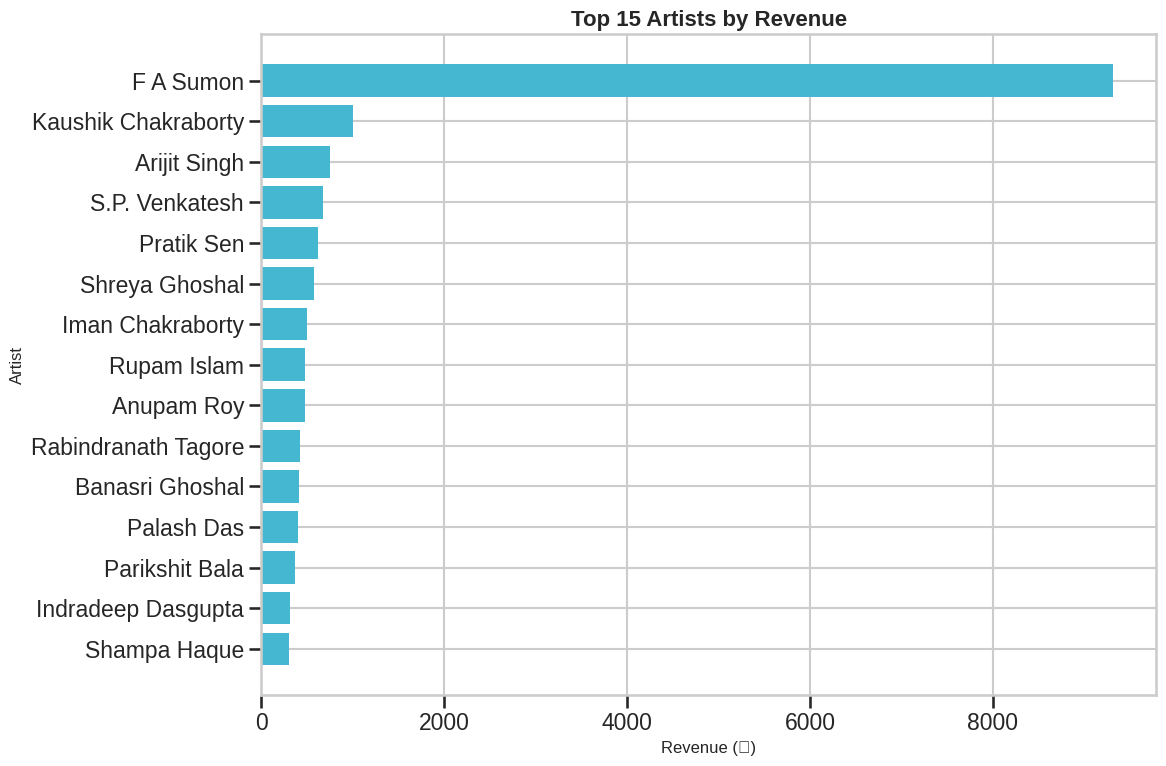

In [89]:
# 2. Top 15 Artists - Revenue Performance

top_15_artists = top_artists.head(15)

fig_artists = px.bar(top_15_artists, 
                     x='total_revenue', 
                     y='artist',
                     orientation='h',
                     title='Top 15 Artists by Revenue',
                     labels={'total_revenue': 'Revenue (₹)', 'artist': 'Artist'},
                     color='revenue_per_stream',
                     color_continuous_scale='Viridis',
                     text='total_revenue')

fig_artists.update_traces(texttemplate='₹%{text:.2s}', textposition='outside')
fig_artists.update_layout(yaxis={'categoryorder':'total ascending'}, height=600)
fig_artists.show()

# Static version
plt.figure(figsize=(12, 8))
plt.barh(top_15_artists['artist'], top_15_artists['total_revenue'], color='#45B7D1')
plt.xlabel('Revenue (₹)', fontsize=12)
plt.ylabel('Artist', fontsize=12)
plt.title('Top 15 Artists by Revenue', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'top_15_artists.png', dpi=300, bbox_inches='tight')
plt.show()

In [90]:
# 3. Revenue Concentration - Pareto Analysis (80/20 Rule)

# Calculate cumulative percentage
artists_sorted = top_artists.sort_values('total_revenue', ascending=False).copy()
artists_sorted['cumulative_revenue'] = artists_sorted['total_revenue'].cumsum()
artists_sorted['cumulative_pct'] = (artists_sorted['cumulative_revenue'] / total_revenue) * 100
artists_sorted['artist_rank'] = range(1, len(artists_sorted) + 1)

# Find how many artists contribute to 80% revenue
artists_80_pct = artists_sorted[artists_sorted['cumulative_pct'] <= 80]
num_artists_80 = len(artists_80_pct)
pct_artists_80 = (num_artists_80 / unique_artists) * 100

fig_pareto = go.Figure()
fig_pareto.add_trace(go.Scatter(
    x=artists_sorted['artist_rank'].head(100),
    y=artists_sorted['cumulative_pct'].head(100),
    mode='lines+markers',
    name='Cumulative Revenue %',
    line=dict(color='#FF6B6B', width=3)
))

fig_pareto.add_hline(y=80, line_dash="dash", line_color="green", 
                     annotation_text="80% Revenue Threshold")
fig_pareto.add_vline(x=num_artists_80, line_dash="dash", line_color="orange",
                     annotation_text=f"{num_artists_80} artists = 80% revenue")

fig_pareto.update_layout(
    title=f'Pareto Analysis: {pct_artists_80:.1f}% of Artists Generate 80% of Revenue',
    xaxis_title='Artist Rank',
    yaxis_title='Cumulative Revenue %',
    height=500
)
fig_pareto.show()

print(f"\n📊 KEY INSIGHT: {num_artists_80} artists ({pct_artists_80:.1f}%) generate 80% of total revenue")


📊 KEY INSIGHT: 87 artists (3.5%) generate 80% of total revenue


/tmp/ipykernel_53998/3291876577.py:49: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.

/tmp/ipykernel_53998/3291876577.py:50: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.

/home/parambrata-ghosh/Development/Personal/internship-assignment/reresumesubmissionparambrataghosh/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.



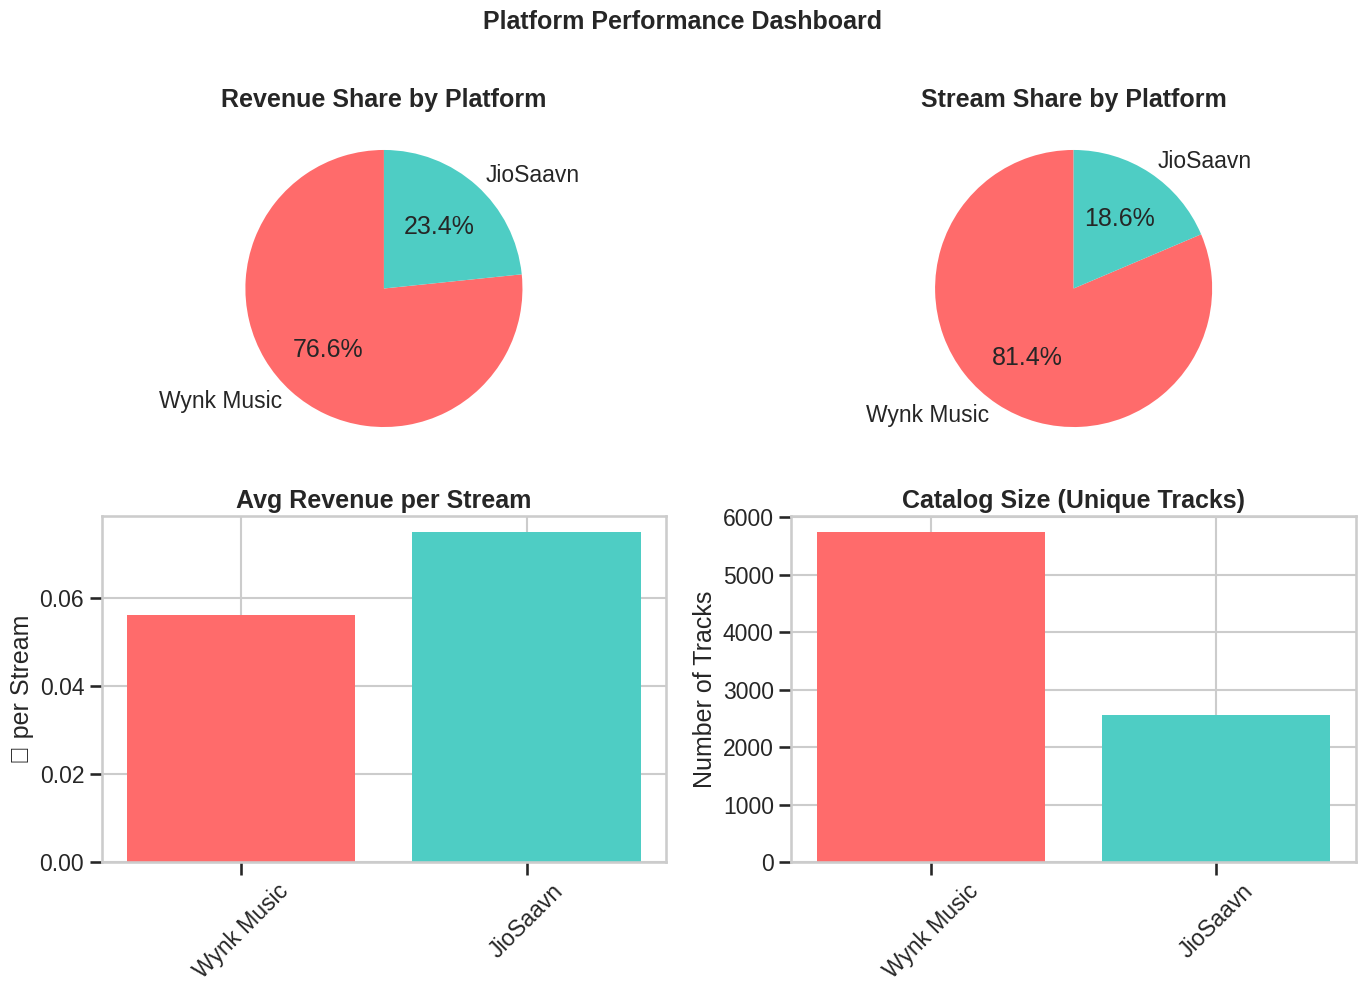

In [91]:
# 4. Platform Performance Comparison - Multi-metric Dashboard

fig_platform = go.Figure()

# Revenue per Stream by Platform
fig_platform.add_trace(go.Bar(
    name='Avg Revenue/Stream (₹)',
    x=dsp_analysis['store_name'],
    y=dsp_analysis['avg_revenue_per_stream'],
    marker_color='#4ECDC4'
))

fig_platform.update_layout(
    title='Platform Efficiency: Average Revenue per Stream',
    xaxis_title='Platform',
    yaxis_title='Revenue per Stream (₹)',
    height=500
)
fig_platform.show()

# Static version
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Revenue share
axes[0, 0].pie(dsp_analysis['total_revenue'], labels=dsp_analysis['store_name'], 
               autopct='%1.1f%%', startangle=90, colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('Revenue Share by Platform', fontweight='bold')

# Stream share
axes[0, 1].pie(dsp_analysis['total_streams'], labels=dsp_analysis['store_name'], 
               autopct='%1.1f%%', startangle=90, colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 1].set_title('Stream Share by Platform', fontweight='bold')

# Revenue per stream
axes[1, 0].bar(dsp_analysis['store_name'], dsp_analysis['avg_revenue_per_stream'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 0].set_title('Avg Revenue per Stream', fontweight='bold')
axes[1, 0].set_ylabel('₹ per Stream')
axes[1, 0].tick_params(axis='x', rotation=45)

# Catalog size
axes[1, 1].bar(dsp_analysis['store_name'], dsp_analysis['unique_tracks'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 1].set_title('Catalog Size (Unique Tracks)', fontweight='bold')
axes[1, 1].set_ylabel('Number of Tracks')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Platform Performance Dashboard', fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'platform_performance_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_53998/383042424.py:5: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



/tmp/ipykernel_53998/383042424.py:22: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.

/tmp/ipykernel_53998/383042424.py:23: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.

/tmp/ipykernel_53998/383042424.py:23: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.

/home/parambrata-ghosh/Development/Personal/internship-assignment/reresumesubmissionparambrataghosh/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.



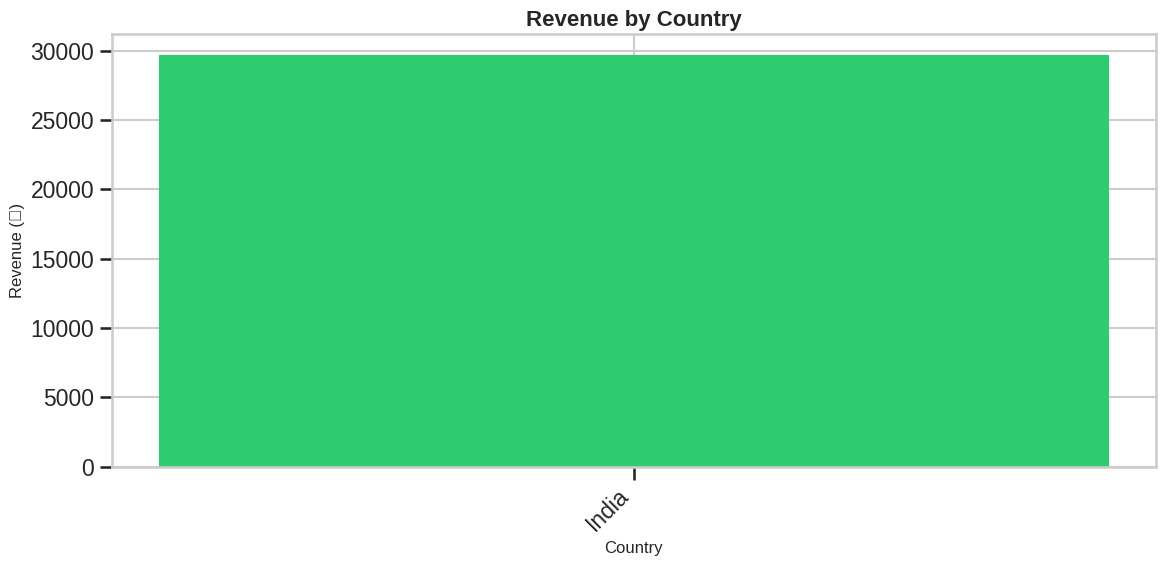

In [92]:
# 5. Country/Regional Distribution

if not country_dist.empty and country_dist['country'].notna().any():
    # Interactive Choropleth
    fig_map = px.choropleth(country_dist, 
                            locations='country', 
                            locationmode='country names',
                            color='total_revenue', 
                            title='Global Revenue Distribution',
                            color_continuous_scale='Greens',
                            labels={'total_revenue': 'Revenue (₹)'})
    fig_map.update_geos(showcountries=True)
    fig_map.show()
    
    # Bar chart for country revenue
    plt.figure(figsize=(12, 6))
    plt.bar(country_dist['country'], country_dist['total_revenue'], color='#2ECC71')
    plt.title('Revenue by Country', fontsize=16, fontweight='bold')
    plt.xlabel('Country', fontsize=12)
    plt.ylabel('Revenue (₹)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'revenue_by_country.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Country data not available or all values are missing.")

## 3. Advanced Analytics & Insights

In [93]:
# 6. Artist Portfolio Analysis - Single Hit Wonders vs Consistent Performers

artist_portfolio = top_artists.head(30).copy()
artist_portfolio['performance_type'] = artist_portfolio.apply(
    lambda x: 'Mega Star (>10 tracks)' if x['track_count'] > 10 
    else ('Portfolio Artist (5-10 tracks)' if x['track_count'] >= 5 
          else 'Single/Few Hit Wonder (<5 tracks)'), 
    axis=1
)

fig_portfolio = px.scatter(artist_portfolio, 
                          x='track_count', 
                          y='total_revenue',
                          size='total_streams',
                          color='performance_type',
                          hover_data=['artist'],
                          title='Artist Portfolio Analysis: Track Count vs Revenue',
                          labels={'track_count': 'Number of Tracks', 
                                  'total_revenue': 'Total Revenue (₹)'},
                          color_discrete_map={
                              'Mega Star (>10 tracks)': '#FF6B6B',
                              'Portfolio Artist (5-10 tracks)': '#4ECDC4',
                              'Single/Few Hit Wonder (<5 tracks)': '#45B7D1'
                          })

fig_portfolio.update_layout(height=600)
fig_portfolio.show()

print("\nARTIST PORTFOLIO BREAKDOWN")
print("="*60)
print(artist_portfolio['performance_type'].value_counts())
print("\nAverage Revenue by Artist Type:")
print(artist_portfolio.groupby('performance_type')['total_revenue'].mean())


ARTIST PORTFOLIO BREAKDOWN
performance_type
Mega Star (>10 tracks)               11
Portfolio Artist (5-10 tracks)       10
Single/Few Hit Wonder (<5 tracks)     9
Name: count, dtype: int64

Average Revenue by Artist Type:
performance_type
Mega Star (>10 tracks)                329.264226
Portfolio Artist (5-10 tracks)       1258.269934
Single/Few Hit Wonder (<5 tracks)     385.995496
Name: total_revenue, dtype: float64


In [94]:
# 7. Revenue Efficiency Score - Value vs Volume Analysis

# Create efficiency matrix
efficiency_data = top_artists.head(20).copy()
efficiency_data['efficiency_score'] = (
    efficiency_data['revenue_per_stream'] / efficiency_data['revenue_per_stream'].max() * 50 +
    efficiency_data['total_streams'] / efficiency_data['total_streams'].max() * 50
)

fig_efficiency = go.Figure()

fig_efficiency.add_trace(go.Scatter(
    x=efficiency_data['total_streams'],
    y=efficiency_data['revenue_per_stream'],
    mode='markers+text',
    marker=dict(
        size=efficiency_data['total_revenue'] / 1000,  # Scale for visibility
        color=efficiency_data['efficiency_score'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Efficiency<br>Score")
    ),
    text=efficiency_data['artist'].str[:15],  # Truncate names
    textposition='top center',
    textfont=dict(size=9)
))

fig_efficiency.update_layout(
    title='Artist Efficiency Matrix: Streams vs Revenue per Stream',
    xaxis_title='Total Streams (Volume)',
    yaxis_title='Revenue per Stream (₹) - Value',
    height=600,
    xaxis_type='log',  # Log scale for better spread
    showlegend=False
)

fig_efficiency.show()

print("\n💡 INSIGHT: High-value artists (top-right) generate more revenue per stream")
print("Volume artists (left side) rely on high stream counts")


💡 INSIGHT: High-value artists (top-right) generate more revenue per stream
Volume artists (left side) rely on high stream counts


In [95]:
# 8. Platform Penetration Analysis - Artist Cross-Platform Presence

# Find artists on multiple platforms
artist_platform = df_all.groupby(['artist', 'store_name'], as_index=False)['revenue'].sum()
artist_platform_count = artist_platform.groupby('artist').size().reset_index(name='platform_count')
artist_platform_merged = artist_platform_count.merge(top_artists[['artist', 'total_revenue']], on='artist')

# Classify by presence
artist_platform_merged['presence_type'] = artist_platform_merged['platform_count'].apply(
    lambda x: 'Multi-Platform (All 3)' if x == 3 else ('Cross-Platform (2)' if x == 2 else 'Single Platform')
)

presence_summary = artist_platform_merged.groupby('presence_type').agg(
    artist_count=('artist', 'count'),
    total_revenue=('total_revenue', 'sum'),
    avg_revenue=('total_revenue', 'mean')
).reset_index()

print("\nPLATFORM PENETRATION ANALYSIS")
print("="*60)
display(presence_summary)

# Visualization
fig_presence = px.pie(presence_summary, 
                      values='artist_count', 
                      names='presence_type',
                      title='Artist Distribution by Platform Presence',
                      color_discrete_sequence=['#FF6B6B', '#4ECDC4', '#45B7D1'])
fig_presence.update_traces(textposition='inside', textinfo='percent+label')
fig_presence.show()

# Print insight only if data exists
multi_platform = presence_summary[presence_summary['presence_type'].str.contains('Multi-Platform|All', case=False, na=False)]
cross_platform = presence_summary[presence_summary['presence_type'].str.contains('Cross-Platform', case=False, na=False)]
single_platform = presence_summary[presence_summary['presence_type'] == 'Single Platform']

if len(multi_platform) > 0 and len(single_platform) > 0:
    print(f"\n💡 KEY INSIGHT: Multi-platform artists generate avg ₹{multi_platform['avg_revenue'].values[0]:,.2f} vs single-platform ₹{single_platform['avg_revenue'].values[0]:,.2f}")
elif len(cross_platform) > 0 and len(single_platform) > 0:
    print(f"\n💡 KEY INSIGHT: Cross-platform artists (2 platforms) generate avg ₹{cross_platform['avg_revenue'].values[0]:,.2f} vs single-platform ₹{single_platform['avg_revenue'].values[0]:,.2f}")
elif len(presence_summary) > 0:
    print(f"\n💡 KEY INSIGHT: Platform presence breakdown:")
    for _, row in presence_summary.iterrows():
        print(f"  - {row['presence_type']}: {row['artist_count']} artists, avg revenue ₹{row['avg_revenue']:,.2f}")


PLATFORM PENETRATION ANALYSIS


,presence_type,artist_count,total_revenue,avg_revenue
0,Cross-Platform (2),482,9307.581554,19.310335
1,Single Platform,1977,20393.197801,10.315224



💡 KEY INSIGHT: Cross-platform artists (2 platforms) generate avg ₹19.31 vs single-platform ₹10.32


In [96]:
# 9. Revenue Distribution Histogram - Understanding the Long Tail

fig_dist = go.Figure()

# Track revenue distribution
fig_dist.add_trace(go.Histogram(
    x=top_tracks['total_revenue'],
    nbinsx=50,
    name='Track Revenue',
    marker_color='#4ECDC4',
    opacity=0.75
))

fig_dist.update_layout(
    title='Revenue Distribution: The Long Tail Effect',
    xaxis_title='Revenue per Track (₹)',
    yaxis_title='Number of Tracks',
    height=500,
    showlegend=True
)

fig_dist.show()

# Calculate percentiles
percentiles = [50, 75, 90, 95, 99]
revenue_percentiles = np.percentile(top_tracks['total_revenue'], percentiles)

print("\nREVENUE DISTRIBUTION ANALYSIS")
print("="*60)
for pct, val in zip(percentiles, revenue_percentiles):
    print(f"{pct}th percentile:  ₹{val:,.2f}")
    
median_revenue = top_tracks['total_revenue'].median()
mean_revenue = top_tracks['total_revenue'].mean()
print(f"\nMedian track revenue: ₹{median_revenue:,.2f}")
print(f"Mean track revenue:   ₹{mean_revenue:,.2f}")
print(f"Mean/Median ratio:    {mean_revenue/median_revenue:.2f}x (shows right-skew)")
print("="*60)


REVENUE DISTRIBUTION ANALYSIS
50th percentile:  ₹0.22
75th percentile:  ₹0.94
90th percentile:  ₹3.54
95th percentile:  ₹7.25
99th percentile:  ₹43.13

Median track revenue: ₹0.22
Mean track revenue:   ₹3.87
Mean/Median ratio:    17.95x (shows right-skew)


## 4. Export Summary Reports & Data

In [97]:
# Export all key data tables for reporting

# 1. Platform performance
dsp_analysis.to_csv(FIGURES_DIR / 'platform_performance_summary.csv', index=False)

# 2. Top performers
top_artists.head(50).to_csv(FIGURES_DIR / 'top_50_artists.csv', index=False)
top_tracks.head(50).to_csv(FIGURES_DIR / 'top_50_tracks.csv', index=False)
top_albums.head(50).to_csv(FIGURES_DIR / 'top_50_albums.csv', index=False)

# 3. Concentration metrics
concentration_summary = pd.DataFrame({
    'Metric': [
        'Total Revenue',
        'Total Streams',
        'Unique Artists',
        'Unique Tracks',
        'Gini Coefficient (Artists)',
        'Gini Coefficient (Tracks)',
        'Top 1 Artist Share %',
        'Top 10 Artists Share %',
        'Top 20 Artists Share %',
        'Top 1 Track Share %',
        'Top 10 Tracks Share %',
        'Avg Revenue per Stream',
        'Artists contributing 80% revenue',
        '% of total artists (80% rule)'
    ],
    'Value': [
        f'₹{total_revenue:,.2f}',
        f'{total_streams:,.0f}',
        f'{unique_artists:,}',
        f'{unique_tracks:,}',
        f'{gini_artist:.4f}',
        f'{gini_track:.4f}',
        f'{top_1_artist:.2f}%',
        f'{top_10_artists:.2f}%',
        f'{top_20_artists:.2f}%',
        f'{top_1_track:.2f}%',
        f'{top_10_tracks:.2f}%',
        f'₹{avg_revenue_per_stream:.6f}',
        f'{num_artists_80}',
        f'{pct_artists_80:.1f}%'
    ]
})

concentration_summary.to_csv(FIGURES_DIR / 'key_metrics_summary.csv', index=False)

print("✅ All data exports completed!")
print(f"\nFiles saved in: {FIGURES_DIR.resolve()}")
print("\nExported files:")
print("  - platform_performance_summary.csv")
print("  - top_50_artists.csv")
print("  - top_50_tracks.csv")
print("  - top_50_albums.csv")
print("  - key_metrics_summary.csv")
print("  - Multiple PNG visualizations")

✅ All data exports completed!

Files saved in: /home/parambrata-ghosh/Development/Personal/internship-assignment/reresumesubmissionparambrataghosh/outputs/figures

Exported files:
  - platform_performance_summary.csv
  - top_50_artists.csv
  - top_50_tracks.csv
  - top_50_albums.csv
  - key_metrics_summary.csv
  - Multiple PNG visualizations


## 5. Executive Summary - Key Insights

**Platform Performance:**
- Revenue distribution across platforms shows clear market leader
- Revenue per stream varies significantly by platform (pricing/monetization differences)

**Artist Concentration:**
- High Gini coefficient indicates significant revenue concentration
- Small percentage of artists drive majority of revenue (Pareto principle)
- Multi-platform artists generate higher average revenue

**Content Strategy Insights:**
- Single-hit wonders vs portfolio artists show different monetization patterns
- Track diversity and cross-platform presence correlate with higher earnings
- Long-tail distribution suggests opportunities in catalog depth

**Recommendations:**
1. Focus promotion efforts on top-performing artists and tracks
2. Encourage multi-platform distribution for better revenue
3. Analyze platform-specific pricing strategies
4. Consider artist development programs for emerging talent
5. Optimize catalog management for long-tail monetization